# 5 Making the VIDEO reference catalogues


Here we will make a video set of reference catalogues

In [1]:
from lsst.meas.algorithms.htmIndexer import HtmIndexer
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.afw.image import abMagErrFromFluxErr, abMagFromFlux

import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.table import Table
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
ORIG = ''
PS_CATS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/"
PS_CATS19 = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110_GmagLT19/"
EX_CAT = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/149504.fits"
EX_MS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/master_schema.fits"
MASS_CAT = '../dmu0/dmu0_2MASS/data/fp_2mass.fp_psc_29182.tbl'

version = 'DR5' #HELP or DR5
#AB HELP catalogue
#
#VISTA Vega DR5 catalogue cut to stars

if version=='DR5':
    VIDEO_CAT = '../dmu0/dmu0_VISTA/dmu0_VIDEO/data/video_dr5_all_pstar09.gz'
elif version=='HELP':
    VIDEO_CAT = '../dmu0/dmu0_VISTA/dmu0_VIDEO/data/VIDEO-all_2017-02-12_fullcat_errfix_v2_XMM-LSS.fits'

In [3]:
t = Table.read(EX_CAT)

In [4]:
t[:5]

id,coord_ra,coord_dec,parent,g_flux,r_flux,i_flux,z_flux,y_flux,i_fluxSigma,y_fluxSigma,r_fluxSigma,z_fluxSigma,g_fluxSigma,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_ra_err,pm_dec_err,footprint
,rad,rad,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int64,float32,float32,float32,float32,int32
108001343677810453,2.345157026052713,-2.197806797133154e-06,0,1.2838545444537885e-06,1.982928552024532e-06,3.01517138723284e-06,4.856765372096561e-06,nan,3.16738379524395e-07,nan,3.629729121712444e-07,6.778826104891778e-07,3.0207684176275507e-07,0.0,0.0,1352273536,0.0,0.0,nan,nan,0
107431343969222916,2.345668457159465,-0.008254100378585155,0,2.007697275985265e-06,6.753069555998081e-06,1.0589669727778528e-05,1.3312220289662946e-05,2.0085879441467114e-05,5.399208475864725e-07,1.157883389169001e-06,2.962838152598124e-07,8.916217097976187e-07,3.1140803002926987e-07,0.0,0.0,1382995072,-0.0027053282,-0.023891896,0.02118348,0.02677908,0
107431343984200158,2.3456946572799193,-0.00829510768268888,0,1.884587049971742e-06,1.9010004734809627e-06,5.857659289176809e-06,8.112950126815122e-06,1.4951265256968327e-05,4.4494140638562385e-07,4.663308175167913e-07,3.0984475074546936e-07,8.782833447185112e-07,2.2170280544742127e-07,0.0,0.0,1361532032,0.07990709,-0.026615456,0.05336448,0.05336448,0
107421343990936666,2.3457072730123314,-0.008344109830567992,0,2.2955191525397822e-06,2.086113454424776e-06,5.038442850491265e-06,7.44710359867895e-06,6.868632681289455e-06,5.957058419880923e-07,1.8847487126549822e-06,2.7256422185928386e-07,5.382827339417418e-07,4.3324499188202026e-07,0.0,0.0,1393959168,-0.096279256,0.0021780662,0.070748076,0.070748076,0
107421344000032859,2.3457229088949574,-0.008399620795089824,0,2.650166607054416e-06,6.488172857643804e-06,9.41978669288801e-06,9.571983355272096e-06,1.6619222151348367e-05,4.193618394765508e-07,1.5774568282722612e-06,3.543551656548516e-07,5.85423322263523e-07,3.2145266004590667e-07,0.0,0.0,1380634624,-0.010534531,0.019350564,0.040031154,0.026171627,0


In [5]:
def getShards(ra, dec, radius):
    htm = HtmIndexer(depth=7)
    shards, onBoundary = htm.getShardIds(SpherePoint(ra*degrees, dec*degrees), radius*degrees)
    return shards
s = getShards(35.428,  -4.90777, 3.0)
s

array([133188, 133200, 133201, 133202, 133203, 133204, 133205, 133206,
       133207, 133208, 133209, 133210, 133211, 133212, 133213, 133214,
       133215, 133234, 133240, 133241, 133243, 133245, 133280, 133281,
       133282, 133283, 133288, 133289, 133291, 133293, 133294, 133295,
       133312, 133313, 133314, 133315, 133316, 133317, 133318, 133319,
       133320, 133321, 133322, 133323, 133324, 133325, 133326, 133327,
       133365, 133368, 133370, 133371, 133372, 133968, 133970, 133971,
       134024, 134048, 134049, 134050, 134051, 134052, 134053, 134054,
       134055, 134057, 134058, 134059, 134060, 134061, 134062, 134063,
       134065, 134068, 134070, 134071, 134078, 134080, 134081, 134083,
       133189, 133190, 133191, 133224, 133232, 133233, 133235, 133242,
       133244, 133246, 133247, 133268, 133285, 133286, 133287, 133290,
       133292, 133296, 133297, 133299, 133336, 133338, 133339, 133348,
       133364, 133366, 133367, 133369, 133373, 133374, 133375, 133969,
      

In [6]:
#Everything in SXDS DUD region
ps_refcats = getShards(36.,  -5.0, 3.0)
files = ''
for c in ps_refcats:
    files += '{}.fits,'.format(c)
print('scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/ps1_pv3_3pi_20170110/\{'
      +files[:-1]+'\} ./')

scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/ps1_pv3_3pi_20170110/\{133200.fits,133201.fits,133202.fits,133203.fits,133204.fits,133205.fits,133206.fits,133207.fits,133208.fits,133209.fits,133210.fits,133211.fits,133212.fits,133213.fits,133214.fits,133215.fits,133232.fits,133234.fits,133235.fits,133240.fits,133241.fits,133243.fits,133245.fits,133268.fits,133280.fits,133281.fits,133282.fits,133283.fits,133288.fits,133289.fits,133290.fits,133291.fits,133292.fits,133293.fits,133294.fits,133295.fits,133296.fits,133297.fits,133299.fits,133312.fits,133313.fits,133314.fits,133315.fits,133316.fits,133317.fits,133318.fits,133319.fits,133320.fits,133321.fits,133322.fits,133323.fits,133324.fits,133325.fits,133326.fits,133327.fits,133336.fits,133364.fits,133365.fits,133367.fits,133368.fits,133369.fits,133370.fits,133371.fits,133372.fits,133373.fits,133375.fits,133968.fits,134048.fits,134049.fits,134050.fits,134051.fits,134052.fits,134053.fits,1

In [7]:
def clean_table(table):
    """Take a table produced by a VO query and remove all empty columns
    
    Often many columns are empty and make the tables hard to read.
    The function also converts columsn that are objects to strings.
    Object columns prevent writing to fits.
    
    Inputs
    =======
    table,    Astropy.table.Table
        The input table
    
    Returns
    =======
    table,    Astropy.table.Table
         The modified table.
    
    """
    table = table.copy()
    if len(table) == 0:
        return table
    for col in table.colnames:
        #Remove empty columns
        try:
            if np.all(table[col].mask):
                print("Removing empty column: {}".format(col))
                table.remove_column(col)
                continue
        except AttributeError:
            pass
            #print("{} is not a masked columns".format(col))
            
        #Get rid of column type object from VO queries
        if table[col].dtype == 'object':
            print("Converting column {} type from object to string".format(col) )
            table[col] = table[col].astype(str)
 
        #Get rid of unit '-' from some tables
        if table[col].unit == '-':
            print("Converting column {} unit from '-' to None".format(col) )
            table[col].unit = None   
            
        #replace masked floats with nans     
        if (
            (table[col].dtype == float) 
            or (table[col].dtype == 'float32')
            or (table[col].dtype == 'float64')
        ):
            table[col].fill_value = np.nan
    
    table = table.filled()
            
    return table

In [8]:
# Conversion from Vega magnitudes to AB is done using values from 
# http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set
# additional terms for VISTA to True Vega from Carlos Gonzalez et al.
vega_to_ab = {
    "z":0.502 + 0.004,
    "y":0.600 - 0.022,
    "j":0.916 + 0.0,
    "h":1.366 + 0.019,
    "ks":1.827 - 0.011,
    #"b118":0.853
}

In [9]:
Table.read(VIDEO_CAT).colnames

['ID',
 'X_IMAGE',
 'Y_IMAGE',
 'ALPHA_J2000',
 'DELTA_J2000',
 'K_X_IMAGE',
 'K_Y_IMAGE',
 'K_ALPHA_J2000',
 'K_DELTA_J2000',
 'K_FLAGS',
 'K_MAG_AUTO',
 'K_MAGERR_AUTO',
 'K_MAG_PETRO',
 'K_MAGERR_PETRO',
 'K_MAG_APER_1',
 'K_MAG_APER_2',
 'K_MAG_APER_3',
 'K_MAG_APER_4',
 'K_MAG_APER_5',
 'K_MAG_APER_6',
 'K_MAG_APER_7',
 'K_MAG_APER_8',
 'K_MAG_APER_9',
 'K_MAG_APER_10',
 'K_MAG_APER_11',
 'K_MAG_APER_12',
 'K_MAG_APER_13',
 'K_MAG_APER_14',
 'K_MAG_APER_15',
 'K_MAGERR_APER_1',
 'K_MAGERR_APER_2',
 'K_MAGERR_APER_3',
 'K_MAGERR_APER_4',
 'K_MAGERR_APER_5',
 'K_MAGERR_APER_6',
 'K_MAGERR_APER_7',
 'K_MAGERR_APER_8',
 'K_MAGERR_APER_9',
 'K_MAGERR_APER_10',
 'K_MAGERR_APER_11',
 'K_MAGERR_APER_12',
 'K_MAGERR_APER_13',
 'K_MAGERR_APER_14',
 'K_MAGERR_APER_15',
 'K_FLUX_AUTO',
 'K_FLUXERR_AUTO',
 'K_FLUX_PETRO',
 'K_FLUXERR_PETRO',
 'K_FLUX_APER_1',
 'K_FLUX_APER_2',
 'K_FLUX_APER_3',
 'K_FLUX_APER_4',
 'K_FLUX_APER_5',
 'K_FLUX_APER_6',
 'K_FLUX_APER_7',
 'K_FLUX_APER_8',
 'K_FLUX_A

In [10]:
# Bands: Z,Y,J,H,K 


if version=='DR5':
    #This is from DR5 public reference (VEGA)
    imported_columns = OrderedDict({
        'SOURCEID': "id",
        'RA': "ra",
        'DEC': "dec",
        'PSTAR':  "stellarity",

        'ZAPERMAG3': "m_ap_vista_z2", 
        'ZAPERMAG3ERR': "merr_ap_vista_z2",

        'YAPERMAG3': "m_ap_vista_y2", 
        'YAPERMAG3ERR': "merr_ap_vista_y2",

        'JAPERMAG3': "m_ap_vista_j", 
        'JAPERMAG3ERR': "merr_ap_vista_j",        

        'HAPERMAG3': "m_ap_vista_h", 
        'HAPERMAG3ERR': "merr_ap_vista_h",        

        'KSAPERMAG3': "m_ap_vista_ks", 
        'KSAPERMAG3ERR': "merr_ap_vista_ks",
    })

elif version=='HELP':
    imported_columns = OrderedDict({
        'ID': "id",
        'ALPHA_J2000': "ra",
        'DELTA_J2000': "dec",
        'K_CLASS_STAR':  "stellarity",
        'Z_MAG_APER_3': "m_ap_vista_z2", 
        'Z_MAGERR_APER_3': "merr_ap_vista_z2",
        'Y_MAG_APER_3': "m_ap_vista_y2", 
        'Y_MAGERR_APER_3': "merr_ap_vista_y2",
        'J_MAG_APER_3': "m_ap_vista_j", 
        'J_MAGERR_APER_3': "merr_ap_vista_j",        
        'H_MAG_APER_3': "m_ap_vista_h", 
        'H_MAGERR_APER_3': "merr_ap_vista_h",        
        'K_MAG_APER_3': "m_ap_vista_ks", 
        'K_MAGERR_APER_3': "merr_ap_vista_ks",
    })

catalogue = Table.read(VIDEO_CAT)[list(imported_columns)]
for column in imported_columns:
    new_col = 'video_' + imported_columns[column]
    catalogue[column].name = new_col
    
    

if version=='DR5':
    catalogue['video_ra'].unit = u.rad
    catalogue['video_dec'].unit = u.rad
elif version=='HELP':
    catalogue['video_ra'].unit = u.deg
    catalogue['video_dec'].unit = u.deg
    catalogue['video_ra'].convert_unit_to(u.rad)
    catalogue['video_dec'].convert_unit_to(u.rad)

for col in catalogue.colnames:
    if col.startswith('video_m_ap'):
        print(col)
        mask = catalogue[col] <= 0
        mask |= catalogue[col] >  30
        catalogue[col][mask] = np.nan
        catalogue[col.replace('video_m', 'video_merr')][mask] = np.nan
        
        
        # Convert magnitude from Vega to AB
        if version=='DR5':
            before = np.nanmean(catalogue[col])
            catalogue[col] += vega_to_ab[col.split('_')[-1].replace('2', '')]
            print(col, vega_to_ab[col.split('_')[-1].replace('2', '')], np.nanmean(catalogue[col])-before)
        elif version=='HELP':
            print('HELP not AB corrected as already AB')
#v_flux = Table.read('../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_XMM-LSS.fits')
v_flux = catalogue[catalogue['video_stellarity'] >= 0.9]

video_m_ap_vista_z2
HELP not AB corrected as already AB
video_m_ap_vista_y2
HELP not AB corrected as already AB
video_m_ap_vista_j
HELP not AB corrected as already AB
video_m_ap_vista_h
HELP not AB corrected as already AB
video_m_ap_vista_ks
HELP not AB corrected as already AB


In [11]:
np.sum(catalogue['video_stellarity'] >= 0.9), len(catalogue)

(48616, 1253838)

In [12]:
v_flux[:5]

video_id,video_ra,video_dec,video_stellarity,video_m_ap_vista_z2,video_merr_ap_vista_z2,video_m_ap_vista_y2,video_merr_ap_vista_y2,video_m_ap_vista_j,video_merr_ap_vista_j,video_m_ap_vista_h,video_merr_ap_vista_h,video_m_ap_vista_ks,video_merr_ap_vista_ks
,rad,rad,,,,,,,,,,,
int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1000001,0.5981014938454109,-0.09846413462577616,0.93058574,22.105032,0.08112372,21.932953,0.21993984,21.88844,0.15433684,nan,nan,20.917292,0.12554654
1000002,0.5969679740298571,-0.09846093690803136,0.98462147,24.96757,1.1925716,19.60957,0.02188538,nan,nan,nan,nan,21.749002,0.333452
1000003,0.601424415119514,-0.0984699163493812,0.92653775,20.837662,0.024121737,19.850422,0.020724466,19.433954,0.020480298,19.923212,0.048840277,19.441927,0.054517895
1000004,0.6011645938626116,-0.09846815392699179,0.95962673,20.811817,0.0266016,20.301064,0.028854508,19.987465,0.03274577,19.658491,0.033496026,19.174896,0.037653107
1000005,0.5981232776429964,-0.09845918584838279,0.9804717,21.547356,0.038574133,21.31623,0.0847303,20.954628,0.043661036,20.334259,0.05125716,20.104551,0.047885254


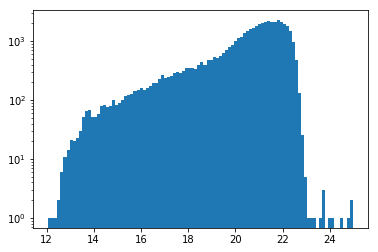

In [13]:
plt.hist(v_flux['video_m_ap_vista_ks'], bins=100)
plt.yscale('log')

In [14]:
np.sum(~np.isnan(v_flux['video_m_ap_vista_ks']))

48608

In [15]:
import astropy.units as u

In [16]:
import astropy.units as u
for col in v_flux.colnames:
    if col.startswith('f'):
        v_flux[col] /= 1.E6
        v_flux[col].unit = u.Jansky


In [17]:
v_flux['video_ra'].unit = u.rad
v_flux['video_dec'].unit = u.rad
v_flux['video_ra'].convert_unit_to(u.rad)
v_flux['video_dec'].convert_unit_to(u.rad)
#v_flux['ra'].name = 'v_ra'
#v_flux['dec'].name = 'v_dec'

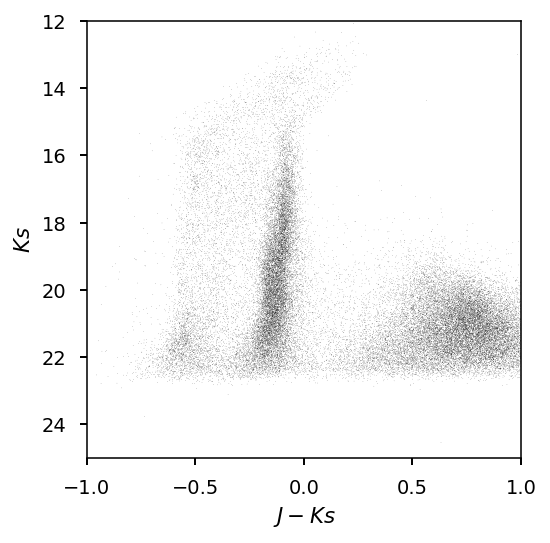

In [18]:
import matplotlib.pyplot as plt
#selected = v_flux['f_vista_y'] / v_flux['ferr_vista_y'] > 5
#selected &= v_flux['f_vista_ks'] / v_flux['ferr_vista_ks'] > 5
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(v_flux['video_m_ap_vista_j'] - v_flux['video_m_ap_vista_ks'],
            v_flux['video_m_ap_vista_ks'],
            edgecolors='None', s=0.05, c='k', rasterized=True)
plt.xlim(-1, 1)
plt.ylim(25, 12)
plt.xlabel('$J-Ks$')
plt.ylabel('$Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

In [19]:
import logging
LOGGER = logging.getLogger(__name__)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
from astropy.table import Table, Column, hstack, vstack
def merge_catalogues(cat_1, cat_2, racol_2, decol_2, radius=0.4*u.arcsec):
    """Merge two catalogues
    This function merges the second catalogue into the first one using the
    given radius to associate identical sources.  This function takes care to
    associate only one source of one catalogue to the other.  The sources that
    may be associated to various counterparts in the other catalogue are
    flagged as “maybe spurious association” with a true value in the
    flag_merged column.  If this column is present in the first catalogue, it's
    content is “inherited” during the merge.
    Parameters
    ----------
    cat_1: astropy.table.Table
        The table containing the first catalogue.  This is the master catalogue
        used during the merge.  If it has a “flag_merged” column it's content
        will be re-used in the flagging of the spurious merges.  This catalogue
        must contain a ‘ra’ and a ‘dec’ columns with the position in decimal
        degrees.
    cat_2: astropy.table.Table
        The table containing the second catalogue.
    racol_2: string
        Name of the column in the second table containing the right ascension
        in decimal degrees.
    decol_2: string
        Name of the column in the second table containing the declination in
        decimal degrees.
    radius: astropy.units.quantity.Quantity
        The radius to associate identical sources in the two catalogues.
    Returns
    -------
    astropy.table.Table
        The merged catalogue.
    """
    cat_1 = cat_1.copy()
    cat_2 = cat_2.copy()
    cat_1['ra'].unit = u.rad
    cat_1['dec'].unit = u.rad
    coords_1 = SkyCoord(cat_1['ra'], cat_1['dec'])

    
    cat_2[racol_2].unit = u.rad
    cat_2[decol_2].unit = u.rad
    coords_2 = SkyCoord(cat_2[racol_2], cat_2[decol_2])

    # Search for sources in second catalogue matching the sources in the first
    # one.
    idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

    # We want to flag the possible mis-associations, i.e. the sources in each
    # catalogue that are associated to several sources in the other one, but
    # also all the sources that are associated to a problematic source in the
    # other catalogue (e.g. if two sources in the first catalogue are
    # associated to the same source in the second catalogue, they must be
    # flagged as potentially problematic).
    #
    # Search for duplicate associations
    toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
    toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
    # Flagging the sources associated to duplicates
    dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
    dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
    toflag_idx_1 = np.unique(np.concatenate(
        (toflag_idx_1, idx_1[dup_associated_in_idx1])
    ))
    toflag_idx_2 = np.unique(np.concatenate(
        (toflag_idx_2, idx_2[dup_associated_in_idx2])
    ))

    # Adding the flags to the catalogue.  In the second catalogue, the column
    # is named "flag_merged_2" and will be combined to the flag_merged column
    # one the merge is done.
    try:
        cat_1["flag_merged"] |= np.in1d(np.arange(len(cat_1), dtype=int),
                                        toflag_idx_1)
    except KeyError:
        cat_1.add_column(Column(
            data=np.in1d(np.arange(len(cat_1), dtype=int), toflag_idx_1),
            name="flag_merged"
        ))
    try:
        cat_2["flag_merged_2"] |= np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2)
    except KeyError:
        cat_2.add_column(Column(
            data=np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2),
            name="flag_merged_2"
        ))


    # Now that we have flagged the maybe spurious associations, we want to
    # associate each source of each catalogue to at most one source in the
    # other one.

    # We sort the indices by the distance to take the nearest counterparts in
    # the following steps.
    sort_idx = np.argsort(d2d)
    idx_1 = idx_1[sort_idx]
    idx_2 = idx_2[sort_idx]

    # These array will contain the indexes of the matching sources in both
    # catalogues.
    match_idx_1 = np.array([], dtype=int)
    match_idx_2 = np.array([], dtype=int)

    while len(idx_1) > 0:

        both_first_idx = np.sort(np.intersect1d(
            np.unique(idx_1, return_index=True)[1],
            np.unique(idx_2, return_index=True)[1],
        ))

        new_match_idx_1 = idx_1[both_first_idx]
        new_match_idx_2 = idx_2[both_first_idx]

        match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
        match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

        # We remove the matching sources in both catalogues.
        to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
        idx_1 = idx_1[~to_remove]
        idx_2 = idx_2[~to_remove]

    # Indices of un-associated object in both catalogues.
    unmatched_idx_1 = np.delete(np.arange(len(cat_1), dtype=int),match_idx_1)
    unmatched_idx_2 = np.delete(np.arange(len(cat_2), dtype=int),match_idx_2)

    # Sources only in cat_1
    only_in_cat_1 = cat_1[unmatched_idx_1]

    # Sources only in cat_2
    only_in_cat_2 = cat_2[unmatched_idx_2]
    # We are using the ra and dec columns from cat_2 for the position.
    only_in_cat_2[racol_2].name = "ra"
    only_in_cat_2[decol_2].name = "dec"

    # Merged table of sources in both catalogues.
    both_in_cat_1_and_cat_2 = hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
    # We don't need the positions from the second catalogue anymore.
    both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

    # Logging the number of rows
    LOGGER.info("There are %s sources only in the first catalogue",
                len(only_in_cat_1))
    LOGGER.info("There are %s sources only in the second catalogue",
                len(only_in_cat_2))
    LOGGER.info("There are %s sources in both catalogues",
                len(both_in_cat_1_and_cat_2))

    merged_catalogue = vstack([only_in_cat_1, both_in_cat_1_and_cat_2,
                               only_in_cat_2])

    # When vertically stacking the catalogues, some values in the flag columns
    # are masked because they did not exist in the catalogue some row originate
    # from. We must set them to the appropriate value.
    for colname in merged_catalogue.colnames:
        if 'flag' in colname:
            merged_catalogue[colname][merged_catalogue[colname].mask] = False

    # We combined the flag_merged flags
    merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
    merged_catalogue.remove_column('flag_merged_2')
    merged_catalogue.remove_column('flag_merged')
    return merged_catalogue

In [20]:
r_cat = Table.read(EX_CAT)

In [21]:
!mkdir -p ./data/ref_cats_video/

In [22]:
#VIDEO REF CAT
for c in ps_refcats:
    r_cat = Table.read("../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/{}.fits".format(c))
    r_cat['coord_ra'].name = 'ra'
    r_cat['coord_dec'].name = 'dec'
    merge = merge_catalogues(r_cat, v_flux, 'video_ra', 'video_dec', radius=0.8*u.arcsec)
    merge=clean_table(merge)
    has_both  = (
        (merge['g_flux'] >0.)
        # &(merge['video_m_ap_vista_ks']>0.) #Take all panstarrs objects
    )

    merge = merge[has_both]
    
    if np.sum(~np.isnan(merge['video_m_ap_vista_ks'])) == 0:
        #print('No VIDEO objects in {}'.format(c))
        continue
    
    merge['ra'].name = 'coord_ra'
    merge['dec'].name = 'coord_dec'
    #convert rad to degs?
    merge['coord_ra'] = (180./np.pi)*merge['coord_ra']
    merge['coord_ra'].unit = u.deg
    merge['coord_dec'] = (180./np.pi)*merge['coord_dec']
    merge['coord_dec'].unit = u.deg
    merge['pm_ra_err'].name = 'pm_raErr'
    merge['pm_dec_err'].name = 'pm_decErr'
    try:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_ra_err']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_dec_err']
        merge['coord_decErr'].unit = u.deg
        merge.remove_columns['coord_ra_err', 'coord_dec_err']
    except:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_raErr']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_decErr']
        merge['coord_decErr'].unit = u.deg
    #flags col only in James Mulaney 19 cut cat
    #merge['flags'].format = '1X'
    merge['epoch'] = merge['epoch'].astype('int32')
    #merge[has_both].write('./data/refcats/{}.fits'.format(c), overwrite=True)
    
    for col in merge.colnames:
        #go through every flux column and convert to mags and rename
        if col.endswith('_flux'):
            err_col = col + 'Sigma'
            mag = abMagFromFlux(merge[col])
            mag_err = abMagErrFromFluxErr(merge[err_col],merge[col])
            merge[col] = mag
            merge[col].name = col[:-5]
            merge[err_col] = mag_err
            merge[err_col].name = err_col.replace('fluxSigma','err')
        #Go through every video mag col and rename
        if col.startswith('video_m_'):
            #Leave just band and replace z/y with z2/y2
            merge[col].name = col.split('_')[-1]
           
            merge[col.replace('video_m_', 'video_merr_')].name =  col.split('_')[-1] + '_err'
    merge.remove_columns(['video_stellarity', 'video_id'])
    merge.write('./data/ref_cats_video/{}.fits'.format(c), overwrite=True)
    ex=merge.copy()
    print("Shard {} has {} objects and {} VIDEO mags.".format(c, len(merge), np.sum(~np.isnan(merge['ks']))))


Shard 133200 has 12877 objects and 1076 VIDEO mags.
Shard 133201 has 12581 objects and 2297 VIDEO mags.
Shard 133202 has 14150 objects and 2012 VIDEO mags.
Shard 133203 has 13422 objects and 2298 VIDEO mags.
Shard 133206 has 13264 objects and 757 VIDEO mags.
Shard 133209 has 11969 objects and 553 VIDEO mags.
Shard 133213 has 14287 objects and 1684 VIDEO mags.
Shard 133214 has 12922 objects and 2051 VIDEO mags.
Shard 133215 has 12812 objects and 1120 VIDEO mags.
Shard 133312 has 14458 objects and 168 VIDEO mags.
Shard 133313 has 12464 objects and 30 VIDEO mags.
Shard 133314 has 12578 objects and 1706 VIDEO mags.
Shard 133315 has 11994 objects and 927 VIDEO mags.
Shard 133317 has 12708 objects and 238 VIDEO mags.
Shard 133318 has 11838 objects and 32 VIDEO mags.
Shard 133319 has 12184 objects and 185 VIDEO mags.
Shard 133321 has 12893 objects and 1452 VIDEO mags.
Shard 133322 has 12242 objects and 714 VIDEO mags.
Shard 133323 has 12732 objects and 940 VIDEO mags.
Shard 133324 has 13102 o

In [23]:
ex[:5]

id,coord_ra,coord_dec,parent,g,r,i,z,y,i_err,y_err,r_err,z_err,g_err,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_raErr,pm_decErr,footprint,z2,z2_err,y2,y2_err,j,j_err,h,h_err,ks,ks_err,coord_raErr,coord_decErr
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
102000336150189610,33.615055772832804,-4.992365720274459,0,23.203859336890282,22.920462990028348,22.597372516334303,21.83790447645081,21.440217487303794,0.10152845890885051,0.15505763643580775,0.15138599045825732,0.08359155981157257,0.124997978301368,0.0,0.0,1287235584,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
102000336167465879,33.61677603160402,-4.995581040426674,0,23.328924185817797,22.42707013215487,22.454738653701654,22.10896968389458,21.438024035415676,0.10910027846970867,0.4016446818804477,0.08139701007898227,0.13097022985105147,0.4033101310777826,0.0,0.0,1381741184,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
102000336175797895,33.61752841068946,-4.993739559853318,0,23.002765118364334,22.30634686488377,21.989848567317004,21.992709619609457,21.97526452207684,0.09036759784017735,0.5206961315464596,0.06322880711046228,0.15342722709380466,0.30672401609613087,0.0,0.0,1359518592,-0.15504418,0.12756622,0.058547765,0.058547765,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
102000336204079019,33.62052577848135,-4.9928261440600465,0,22.26027485774202,21.998281479300466,21.92338227819349,21.969873916664366,21.6731048225206,0.07590481062326625,0.3303725717235499,0.06194911292465103,0.13306380579239058,0.07187450110276465,0.0,0.0,1362958080,0.024887713,0.038875565,0.048299156,0.041723315,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
102000336249378659,33.624975362939416,-4.993170884679092,0,22.915546868496953,23.306972919448505,22.897026580555654,22.50781050780452,21.067924541461437,0.22315583362231886,0.2232926199008319,0.1545802278412069,0.2531914787219304,0.08686732078893715,0.0,0.0,1344090112,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0


In [24]:
np.sum(~np.isnan(ex['z2']))

1102